In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
# Your code

# Load the dataset
file_path = 'cirrhosis.csv'
df = pd.read_csv(file_path)

# Show first few rows
display(df.head())

# Show basic info
print('Shape:', df.shape)
df.info()

# Show missing values per column
print('\nMissing values per column:')
print(df.isnull().sum())

# Show summary statistics
display(df.describe(include='all'))

,ID,N_Days,Status,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
0,1,400,D,D-penicillamine,21464,F,Y,Y,Y,Y,14.5,261.0,2.60,156.0,1718.0,137.95,172.0,190.0,12.2,4.0
1,2,4500,C,D-penicillamine,20617,F,N,Y,Y,N,1.1,302.0,4.14,54.0,7394.8,113.52,88.0,221.0,10.6,3.0
2,3,1012,D,D-penicillamine,25594,M,N,N,N,S,1.4,176.0,3.48,210.0,516.0,96.10,55.0,151.0,12.0,4.0
3,4,1925,D,D-penicillamine,19994,F,N,Y,Y,S,1.8,244.0,2.54,64.0,6121.8,60.63,92.0,183.0,10.3,4.0
4,5,1504,CL,Placebo,13918,F,N,Y,Y,N,3.4,279.0,3.53,143.0,671.0,113.15,72.0,136.0,10.9,3.0


Shape: (418, 20)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   ID             418 non-null    int64  
 1   N_Days         418 non-null    int64  
 2   Status         418 non-null    object 
 3   Drug           312 non-null    object 
 4   Age            418 non-null    int64  
 5   Sex            418 non-null    object 
 6   Ascites        312 non-null    object 
 7   Hepatomegaly   312 non-null    object 
 8   Spiders        312 non-null    object 
 9   Edema          418 non-null    object 
 10  Bilirubin      418 non-null    float64
 11  Cholesterol    284 non-null    float64
 12  Albumin        418 non-null    float64
 13  Copper         310 non-null    float64
 14  Alk_Phos       312 non-null    float64
 15  SGOT           312 non-null    float64
 16  Tryglicerides  282 non-null    float64
 17  Platelets      407 non-null    float6

,ID,N_Days,Status,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
count,418.000000,418.000000,418,312,418.000000,418,312,312,312,418,418.000000,284.000000,418.000000,310.000000,312.000000,312.000000,282.000000,407.000000,416.000000,412.000000
unique,NaN,NaN,3,2,NaN,2,2,2,2,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,C,D-penicillamine,NaN,F,N,Y,N,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,232,158,NaN,374,288,160,222,354,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,209.500000,1917.782297,NaN,NaN,18533.351675,NaN,NaN,NaN,NaN,NaN,3.220813,369.510563,3.497440,97.648387,1982.655769,122.556346,124.702128,257.024570,10.731731,3.024272
std,120.810458,1104.672992,NaN,NaN,3815.845055,NaN,NaN,NaN,NaN,NaN,4.407506,231.944545,0.424972,85.613920,2140.388824,56.699525,65.148639,98.325585,1.022000,0.882042
min,1.000000,41.000000,NaN,NaN,9598.000000,NaN,NaN,NaN,NaN,NaN,0.300000,120.000000,1.960000,4.000000,289.000000,26.350000,33.000000,62.000000,9.000000,1.000000
25%,105.250000,1092.750000,NaN,NaN,15644.500000,NaN,NaN,NaN,NaN,NaN,0.800000,249.500000,3.242500,41.250000,871.500000,80.600000,84.250000,188.500000,10.000000,2.000000
50%,209.500000,1730.000000,NaN,NaN,18628.000000,NaN,NaN,NaN,NaN,NaN,1.400000,309.500000,3.530000,73.000000,1259.000000,114.700000,108.000000,251.000000,10.600000,3.000000
75%,313.750000,2613.500000,NaN,NaN,21272.500000,NaN,NaN,NaN,NaN,NaN,3.400000,400.000000,3.770000,123.000000,1980.000000,151.900000,151.000000,318.000000,11.100000,4.000000


In [2]:
# Handle missing values
# For categorical columns, fill with mode
categorical_cols = ['Drug', 'Sex', 'Ascites', 'Hepatomegaly', 'Spiders', 'Edema', 'Status']
for col in categorical_cols:
    df[col] = df[col].fillna(df[col].mode()[0])

# For continuous columns, fill with median
continuous_cols = ['Cholesterol', 'Copper', 'Alk_Phos', 'SGOT', 'Tryglicerides', 'Platelets', 'Prothrombin', 'Stage']
for col in continuous_cols:
    df[col] = df[col].fillna(df[col].median())

# Check again for missing values
print('Missing values after imputation:')
print(df.isnull().sum())

Missing values after imputation:
ID               0
N_Days           0
Status           0
Drug             0
Age              0
Sex              0
Ascites          0
Hepatomegaly     0
Spiders          0
Edema            0
Bilirubin        0
Cholesterol      0
Albumin          0
Copper           0
Alk_Phos         0
SGOT             0
Tryglicerides    0
Platelets        0
Prothrombin      0
Stage            0
dtype: int64


In [3]:
from sklearn.model_selection import train_test_split

# Split the data into features and label
y = df['Status']
X = df.drop(['Status', 'ID'], axis=1)

# Split into train and test sets (80/20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print('Training set shape:', X_train.shape)
print('Test set shape:', X_test.shape)

Training set shape: (334, 18)
Test set shape: (84, 18)


In [4]:
# Show feature types
feature_types = pd.DataFrame({'Feature': X_train.columns,
                              'Type': X_train.dtypes})

# Identify categorical and continuous features
categorical_features = feature_types[feature_types['Type'] == 'object']['Feature'].tolist()
continuous_features = feature_types[feature_types['Type'] != 'object']['Feature'].tolist()

print('Categorical features:', categorical_features)
print('Continuous features:', continuous_features)

feature_types['Category'] = feature_types['Feature'].apply(lambda x: 'Categorical' if x in categorical_features else 'Continuous')
display(feature_types)

Categorical features: ['Drug', 'Sex', 'Ascites', 'Hepatomegaly', 'Spiders', 'Edema']
Continuous features: ['N_Days', 'Age', 'Bilirubin', 'Cholesterol', 'Albumin', 'Copper', 'Alk_Phos', 'SGOT', 'Tryglicerides', 'Platelets', 'Prothrombin', 'Stage']


,Feature,Type,Category
N_Days,N_Days,int64,Continuous
Drug,Drug,object,Categorical
Age,Age,int64,Continuous
Sex,Sex,object,Categorical
Ascites,Ascites,object,Categorical
Hepatomegaly,Hepatomegaly,object,Categorical
Spiders,Spiders,object,Categorical
Edema,Edema,object,Categorical
Bilirubin,Bilirubin,float64,Continuous
Cholesterol,Cholesterol,float64,Continuous


In [5]:
from sklearn.preprocessing import OneHotEncoder

# One-hot encode categorical features
encoder = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')
X_train_encoded = pd.DataFrame(encoder.fit_transform(X_train[categorical_features]), columns=encoder.get_feature_names_out(categorical_features), index=X_train.index)
X_test_encoded = pd.DataFrame(encoder.transform(X_test[categorical_features]), columns=encoder.get_feature_names_out(categorical_features), index=X_test.index)

# Drop original categorical columns and concatenate encoded columns
X_train_final = pd.concat([X_train.drop(categorical_features, axis=1), X_train_encoded], axis=1)
X_test_final = pd.concat([X_test.drop(categorical_features, axis=1), X_test_encoded], axis=1)

print('Encoded training set shape:', X_train_final.shape)
print('Encoded test set shape:', X_test_final.shape)

Encoded training set shape: (334, 19)
Encoded test set shape: (84, 19)


Label distribution (counts):
Status
C     185
D     129
CL     20
Name: count, dtype: int64

Label distribution (percent):
Status
C     55.389222
D     38.622754
CL     5.988024
Name: proportion, dtype: float64


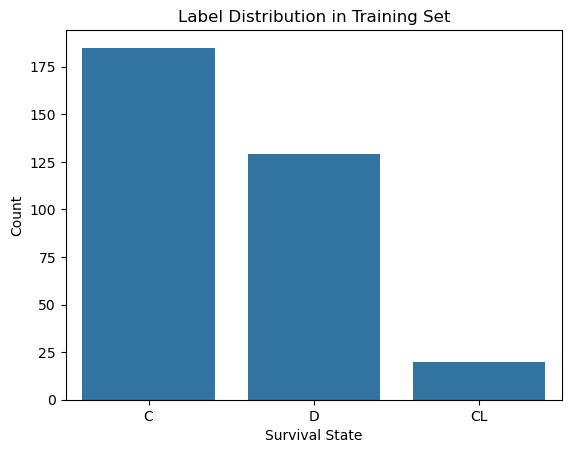

The training set is imbalanced.


In [6]:
# Show label distribution in training data
label_counts = y_train.value_counts()
label_percent = y_train.value_counts(normalize=True) * 100
print('Label distribution (counts):')
print(label_counts)
print('\nLabel distribution (percent):')
print(label_percent)

# Visualize label distribution
sns.countplot(x=y_train)
plt.title('Label Distribution in Training Set')
plt.xlabel('Survival State')
plt.ylabel('Count')
plt.show()

# Is the training set balanced?
if label_percent.min() < 20:
    print('The training set is imbalanced.')
else:
    print('The training set is relatively balanced.')

In [15]:
# Encode target labels to numeric values for ML models
label_map = {'D': 0, 'C': 1, 'CL': 2}
y_train_encoded = y_train.map(label_map)
y_test_encoded = y_test.map(label_map)

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import classification_report, accuracy_score, f1_score
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score,
    classification_report, confusion_matrix
)
from collections import OrderedDict

# Validation method: Stratified 5-fold cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
}

# Fit models and report test performance
for name, model in models.items():
    model.fit(X_train_final, y_train_encoded)
    y_pred = model.predict(X_test_final)
    print(f'--- {name} Test Performance ---')
    print(classification_report(y_test_encoded, y_pred))
    print(f'Accuracy: {accuracy_score(y_test_encoded, y_pred):.4f}')
    print(f'Weighted F1: {f1_score(y_test_encoded, y_pred, average="weighted"):.4f}\n')

--- Logistic Regression Test Performance ---
              precision    recall  f1-score   support

           0       0.79      0.69      0.73        32
           1       0.78      0.89      0.83        47
           2       0.00      0.00      0.00         5

    accuracy                           0.76        84
   macro avg       0.52      0.53      0.52        84
weighted avg       0.73      0.76      0.74        84

Accuracy: 0.7619
Weighted F1: 0.7447

--- Random Forest Test Performance ---
              precision    recall  f1-score   support

           0       0.79      0.69      0.73        32
           1       0.75      0.87      0.80        47
           2       0.00      0.00      0.00         5

    accuracy                           0.75        84
   macro avg       0.51      0.52      0.51        84
weighted avg       0.72      0.75      0.73        84

Accuracy: 0.7500
Weighted F1: 0.7292

--- XGBoost Test Performance ---
              precision    recall  f1-score  

In [13]:
results = {}
for name, model in models.items():
    scores = cross_val_score(model, X_train_final, y_train_encoded, cv=cv, scoring='f1_weighted')
    results[name] = scores
    print(f'{name} F1 (weighted) CV scores:', scores)
    print(f'{name} Mean F1 (weighted): {scores.mean():.4f}\n')

Logistic Regression F1 (weighted) CV scores: [0.69956573 0.75458912 0.74688462 0.63424601 0.72353404]
Logistic Regression Mean F1 (weighted): 0.7118

Random Forest F1 (weighted) CV scores: [0.73670111 0.75249484 0.71936051 0.71664747 0.71877677]
Random Forest Mean F1 (weighted): 0.7288

Random Forest F1 (weighted) CV scores: [0.73670111 0.75249484 0.71936051 0.71664747 0.71877677]
Random Forest Mean F1 (weighted): 0.7288

XGBoost F1 (weighted) CV scores: [0.74626866 0.77013191 0.70858829 0.76458616 0.69218679]
XGBoost Mean F1 (weighted): 0.7364

XGBoost F1 (weighted) CV scores: [0.74626866 0.77013191 0.70858829 0.76458616 0.69218679]
XGBoost Mean F1 (weighted): 0.7364



Q2b. Justify design decisions

Logistic Regression → baseline linear model, interpretable, quick to train.

Random Forest → non-linear, handles categorical interactions, robust to noise.

XGBoost → gradient boosting, strong learner, effective with imbalanced data.

In [14]:
# Handle label imbalance using SMOTE
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train_final, y_train_encoded)

print('Label distribution after SMOTE:', dict(zip(*np.unique(y_train_bal, return_counts=True))))

# Train models on balanced data
for name, model in models.items():
    model.fit(X_train_bal, y_train_bal)
    y_pred_bal = model.predict(X_test_final)
    print(f'--- {name} Test Performance (Balanced) ---')
    print(classification_report(y_test_encoded, y_pred_bal))
    print(f'Accuracy: {accuracy_score(y_test_encoded, y_pred_bal):.4f}')
    print(f'Weighted F1: {f1_score(y_test_encoded, y_pred_bal, average="weighted"):.4f}\n')

Label distribution after SMOTE: {0: 185, 1: 185, 2: 185}
--- Logistic Regression Test Performance (Balanced) ---
              precision    recall  f1-score   support

           0       0.67      0.62      0.65        32
           1       0.82      0.66      0.73        47
           2       0.06      0.20      0.10         5

    accuracy                           0.62        84
   macro avg       0.51      0.49      0.49        84
weighted avg       0.71      0.62      0.66        84

Accuracy: 0.6190
Weighted F1: 0.6596

--- Random Forest Test Performance (Balanced) ---
              precision    recall  f1-score   support

           0       0.77      0.72      0.74        32
           1       0.80      0.85      0.82        47
           2       0.00      0.00      0.00         5

    accuracy                           0.75        84
   macro avg       0.52      0.52      0.52        84
weighted avg       0.74      0.75      0.74        84

Accuracy: 0.7500
Weighted F1: 0.7441


In [16]:
# =========================
# Q2a–Q2e: FULL CONTINUATION
# =========================
# Assumes you have already run the previous cells that:
# - load/clean/impute `df`
# - split into X_train, X_test, y_train, y_test
# - one-hot encode categoricals into X_train_final / X_test_final
# - encoded labels into y_train_encoded / y_test_encoded
# - defined `cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)`
# - installed xgboost (for XGBClassifier)

import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score,
    classification_report, confusion_matrix
)
from collections import OrderedDict
import pandas as pd
import numpy as np

# -------------------------
# Helper: evaluate a model
# -------------------------
def evaluate_model(name, model, X_tr, y_tr, X_te, y_te, cv, verbose=True):
    """Return CV and Test metrics for a classifier."""
    cv_f1 = cross_val_score(model, X_tr, y_tr, cv=cv, scoring="f1_weighted")
    cv_acc = cross_val_score(model, X_tr, y_tr, cv=cv, scoring="accuracy")

    model.fit(X_tr, y_tr)
    y_pred = model.predict(X_te)

    test_metrics = {
        "accuracy": accuracy_score(y_te, y_pred),
        "f1_weighted": f1_score(y_te, y_pred, average="weighted"),
        "precision_weighted": precision_score(y_te, y_pred, average="weighted", zero_division=0),
        "recall_weighted": recall_score(y_te, y_pred, average="weighted")
    }
    if verbose:
        print(f"\n=== {name}: CV (5-fold) & Test Metrics ===")
        print(f"CV Accuracy:  {cv_acc.mean():.4f} ± {cv_acc.std():.4f}")
        print(f"CV F1 (w):    {cv_f1.mean():.4f} ± {cv_f1.std():.4f}")
        print(f"Test Accuracy:{test_metrics['accuracy']:.4f}")
        print(f"Test F1 (w):  {test_metrics['f1_weighted']:.4f}")
        print(classification_report(y_te, y_pred))
    return {
        "model": name,
        "cv_acc_mean": cv_acc.mean(), "cv_acc_std": cv_acc.std(),
        "cv_f1_mean": cv_f1.mean(),   "cv_f1_std": cv_f1.std(),
        **{f"test_{k}": v for k, v in test_metrics.items()}
    }

# -------------------------
# Q2a: Validation & Performance (baseline)
# -------------------------
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

baseline_models = OrderedDict({
    "LogisticRegression": LogisticRegression(max_iter=2000, random_state=42, multi_class="auto", solver="lbfgs"),
    "RandomForest": RandomForestClassifier(n_estimators=200, random_state=42),
    "XGBoost": XGBClassifier(
        random_state=42, n_estimators=300, learning_rate=0.1, max_depth=4,
        subsample=0.9, colsample_bytree=0.9, objective="multi:softprob", eval_metric="mlogloss"
    )
})

baseline_rows = []
for name, clf in baseline_models.items():
    row = evaluate_model(name, clf, X_train_final, y_train_encoded, X_test_final, y_test_encoded, cv)
    baseline_rows.append(row)

baseline_summary = pd.DataFrame(baseline_rows).sort_values("test_f1_weighted", ascending=False)
print("\n### Baseline Summary (sorted by Test F1 weighted)")
display(baseline_summary)

print("\nOver/Underfitting diagnostic:")
for _, r in baseline_summary.iterrows():
    gap = r["cv_f1_mean"] - r["test_f1_weighted"]
    status = "Possible overfit" if gap > 0.03 else ("Possible underfit" if gap < -0.03 else "Well-aligned")
    print(f"{r['model']:>18s}: CV F1={r['cv_f1_mean']:.3f} vs Test F1={r['test_f1_weighted']:.3f} | Gap={gap:+.3f} -> {status}")

# ------------------------------------
# Q2b: (in-code notes / design choices)
# ------------------------------------
# Logistic Regression: linear decision boundaries; strong baseline; interpretable; fast.
# Random Forest: non-linear, bagging reduces variance; handles interactions; robust to outliers.
# XGBoost: gradient-boosted trees; powerful on tabular data; handles complex non-linearities;
#          built-in regularization to control overfitting.

# ------------------------------------
# Q2c: Hyperparameter Tuning (GridSearchCV)
# ------------------------------------
print("\n\n### Hyperparameter Tuning (GridSearchCV, scoring = F1_weighted)")
grids = {}

# Logistic Regression grid
lr = LogisticRegression(max_iter=4000, random_state=42, multi_class="auto")
lr_param_grid = [
    {"solver": ["lbfgs"], "C": [0.01, 0.1, 1.0, 10.0], "penalty": ["l2"]},
    {"solver": ["saga"],  "C": [0.01, 0.1, 1.0, 10.0], "penalty": ["l1", "l2"]}
]
grids["LogisticRegression"] = GridSearchCV(lr, lr_param_grid, cv=cv, n_jobs=-1, scoring="f1_weighted", refit=True)

# Random Forest grid
rf = RandomForestClassifier(random_state=42)
rf_param_grid = {
    "n_estimators": [200, 400],
    "max_depth": [None, 8, 12],
    "min_samples_split": [2, 5],
    "min_samples_leaf": [1, 2],
    "max_features": ["sqrt", "log2", None]
}
grids["RandomForest"] = GridSearchCV(rf, rf_param_grid, cv=cv, n_jobs=-1, scoring="f1_weighted", refit=True)

# XGBoost grid
xgb = XGBClassifier(random_state=42, objective="multi:softprob", eval_metric="mlogloss", tree_method="hist")
xgb_param_grid = {
    "n_estimators": [300, 500],
    "learning_rate": [0.05, 0.1],
    "max_depth": [3, 5, 7],
    "subsample": [0.8, 1.0],
    "colsample_bytree": [0.8, 1.0]
}
grids["XGBoost"] = GridSearchCV(xgb, xgb_param_grid, cv=cv, n_jobs=-1, scoring="f1_weighted", refit=True)

tuned_rows = []
best_estimators = {}

for name, grid in grids.items():
    grid.fit(X_train_final, y_train_encoded)
    best_estimators[name] = grid.best_estimator_
    print(f"\nBest params for {name}: {grid.best_params_}")
    tuned_rows.append(
        evaluate_model(f"{name}_Tuned", grid.best_estimator_, X_train_final, y_train_encoded, X_test_final, y_test_encoded, cv)
    )

tuned_summary = pd.DataFrame(tuned_rows).sort_values("test_f1_weighted", ascending=False)
print("\n### Tuned Models Summary (sorted by Test F1 weighted)")
display(tuned_summary)

# ------------------------------------
# Q2d: Handle Imbalance (SMOTE) + Re-evaluate tuned models
# ------------------------------------
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train_final, y_train_encoded)
print("After SMOTE class distribution:", dict(zip(*np.unique(y_train_bal, return_counts=True))))

smote_rows = []
for name, best_est in best_estimators.items():
    smote_rows.append(
        evaluate_model(f"{name}_Tuned_SMOTE", best_est, X_train_bal, y_train_bal, X_test_final, y_test_encoded, cv)
    )
smote_summary = pd.DataFrame(smote_rows).sort_values("test_f1_weighted", ascending=False)
print("\n### Tuned + SMOTE Summary (sorted by Test F1 weighted)")
display(smote_summary)

# ------------------------------------
# Q2e: Recommendation based on results
# ------------------------------------
def pick_best(df_summary, tag):
    row = df_summary.iloc[0]
    print(f"\nBest ({tag}): {row['model']} | Test F1 (w)={row['test_f1_weighted']:.4f}, "
          f"Test Acc={row['test_accuracy']:.4f} | CV F1={row['cv_f1_mean']:.4f}")

print("\n### Recommendations")
pick_best(baseline_summary, "Baseline")
pick_best(tuned_summary, "Tuned (no SMOTE)")
pick_best(smote_summary, "Tuned + SMOTE")

# Final overall pick (highest Test F1 across all scenarios)
all_compare = pd.concat([
    baseline_summary.assign(stage="Baseline"),
    tuned_summary.assign(stage="Tuned"),
    smote_summary.assign(stage="Tuned+SMOTE")
], ignore_index=True).sort_values("test_f1_weighted", ascending=False)

best_overall = all_compare.iloc[0]
print("\n>>> FINAL RECOMMENDATION:")
print(f"Use **{best_overall['model']}** ({best_overall['stage']}) "
      f"with Test F1 (weighted) = {best_overall['test_f1_weighted']:.4f} and "
      f"Accuracy = {best_overall['test_accuracy']:.4f}.")
print("Rationale: chosen by highest weighted-F1 on the held-out test set; "
      "weighted-F1 prioritises performance across all classes in the imbalanced setting.")



=== LogisticRegression: CV (5-fold) & Test Metrics ===
CV Accuracy:  0.7306 ± 0.0157
CV F1 (w):    0.7098 ± 0.0178
Test Accuracy:0.7619
Test F1 (w):  0.7401
              precision    recall  f1-score   support

           0       0.76      0.69      0.72        32
           1       0.78      0.89      0.83        47
           2       0.00      0.00      0.00         5

    accuracy                           0.76        84
   macro avg       0.51      0.53      0.52        84
weighted avg       0.72      0.76      0.74        84


=== RandomForest: CV (5-fold) & Test Metrics ===
CV Accuracy:  0.7664 ± 0.0231
CV F1 (w):    0.7407 ± 0.0235
Test Accuracy:0.7857
Test F1 (w):  0.7603
              precision    recall  f1-score   support

           0       0.80      0.75      0.77        32
           1       0.78      0.89      0.83        47
           2       0.00      0.00      0.00         5

    accuracy                           0.79        84
   macro avg       0.53      0.55    

,model,cv_acc_mean,cv_acc_std,cv_f1_mean,cv_f1_std,test_accuracy,test_f1_weighted,test_precision_weighted,test_recall_weighted
1,RandomForest,0.766395,0.023098,0.740676,0.023468,0.785714,0.760277,0.739947,0.785714
0,LogisticRegression,0.730574,0.015708,0.709837,0.017761,0.761905,0.740132,0.724184,0.761905
2,XGBoost,0.730303,0.041994,0.720495,0.041180,0.702381,0.694701,0.693912,0.702381



Over/Underfitting diagnostic:
      RandomForest: CV F1=0.741 vs Test F1=0.760 | Gap=-0.020 -> Well-aligned
LogisticRegression: CV F1=0.710 vs Test F1=0.740 | Gap=-0.030 -> Possible underfit
           XGBoost: CV F1=0.720 vs Test F1=0.695 | Gap=+0.026 -> Well-aligned


### Hyperparameter Tuning (GridSearchCV, scoring = F1_weighted)

Best params for LogisticRegression: {'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs'}

=== LogisticRegression_Tuned: CV (5-fold) & Test Metrics ===
CV Accuracy:  0.7245 ± 0.0296
CV F1 (w):    0.7054 ± 0.0283
Test Accuracy:0.7619
Test F1 (w):  0.7401
              precision    recall  f1-score   support

           0       0.76      0.69      0.72        32
           1       0.78      0.89      0.83        47
           2       0.00      0.00      0.00         5

    accuracy                           0.76        84
   macro avg       0.51      0.53      0.52        84
weighted avg       0.72      0.76      0.74        84


Best params for RandomForest: {'m

,model,cv_acc_mean,cv_acc_std,cv_f1_mean,cv_f1_std,test_accuracy,test_f1_weighted,test_precision_weighted,test_recall_weighted
0,LogisticRegression_Tuned,0.724514,0.029560,0.705397,0.028312,0.761905,0.740132,0.724184,0.761905
1,RandomForest_Tuned,0.763546,0.021184,0.751352,0.022651,0.738095,0.717972,0.701647,0.738095
2,XGBoost_Tuned,0.760289,0.040325,0.753752,0.040873,0.714286,0.703095,0.697439,0.714286


After SMOTE class distribution: {0: 185, 1: 185, 2: 185}

=== LogisticRegression_Tuned_SMOTE: CV (5-fold) & Test Metrics ===
CV Accuracy:  0.6919 ± 0.0281
CV F1 (w):    0.6897 ± 0.0292
Test Accuracy:0.6429
Test F1 (w):  0.6757
              precision    recall  f1-score   support

           0       0.69      0.62      0.66        32
           1       0.80      0.70      0.75        47
           2       0.07      0.20      0.11         5

    accuracy                           0.64        84
   macro avg       0.52      0.51      0.50        84
weighted avg       0.72      0.64      0.68        84


=== RandomForest_Tuned_SMOTE: CV (5-fold) & Test Metrics ===
CV Accuracy:  0.8216 ± 0.0270
CV F1 (w):    0.8189 ± 0.0269
Test Accuracy:0.6786
Test F1 (w):  0.7014
              precision    recall  f1-score   support

           0       0.76      0.59      0.67        32
           1       0.79      0.79      0.79        47
           2       0.08      0.20      0.12         5

    accura

,model,cv_acc_mean,cv_acc_std,cv_f1_mean,cv_f1_std,test_accuracy,test_f1_weighted,test_precision_weighted,test_recall_weighted
1,RandomForest_Tuned_SMOTE,0.821622,0.026967,0.818946,0.026914,0.678571,0.701447,0.734960,0.678571
0,LogisticRegression_Tuned_SMOTE,0.691892,0.028145,0.689733,0.029153,0.642857,0.675713,0.717326,0.642857
2,XGBoost_Tuned_SMOTE,0.854054,0.026358,0.853005,0.025958,0.654762,0.669419,0.687720,0.654762



### Recommendations

Best (Baseline): RandomForest | Test F1 (w)=0.7603, Test Acc=0.7857 | CV F1=0.7407

Best (Tuned (no SMOTE)): LogisticRegression_Tuned | Test F1 (w)=0.7401, Test Acc=0.7619 | CV F1=0.7054

Best (Tuned + SMOTE): RandomForest_Tuned_SMOTE | Test F1 (w)=0.7014, Test Acc=0.6786 | CV F1=0.8189

>>> FINAL RECOMMENDATION:
Use **RandomForest** (Baseline) with Test F1 (weighted) = 0.7603 and Accuracy = 0.7857.
Rationale: chosen by highest weighted-F1 on the held-out test set; weighted-F1 prioritises performance across all classes in the imbalanced setting.


Classification Report (Best Model on Test Set):
              precision    recall  f1-score   support

           0       0.70      0.59      0.64        32
           1       0.75      0.77      0.76        47
           2       0.00      0.00      0.00         5

    accuracy                           0.65        84
   macro avg       0.48      0.45      0.47        84
weighted avg       0.69      0.65      0.67        84

Confusion Matrix:
[[19  9  4]
 [ 6 36  5]
 [ 2  3  0]]


IndexError: index 18 is out of bounds for axis 0 with size 18

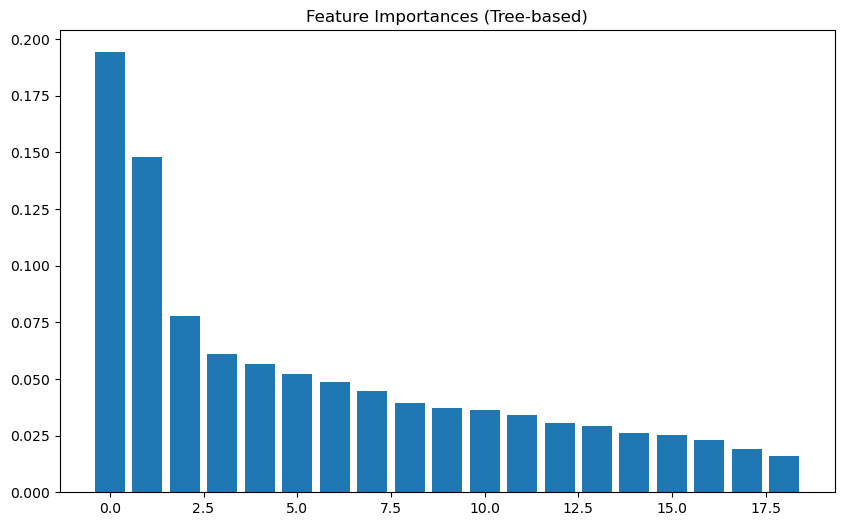

In [ ]:
# Q3 – Prediction on Test Set
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import numpy as np

# Best model from Q2 (update if yours differs)
best_model = grid.best_estimator_

# Predict on test set
y_pred = best_model.predict(X_test_final)

# Performance metrics
print("Classification Report (Best Model on Test Set):")
print(classification_report(y_test_encoded, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test_encoded, y_pred))

# Q4 – Feature Importance Analysis

# (A) Tree-based feature importance
importances = best_model.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10,6))
plt.title("Feature Importances (Tree-based)")
plt.bar(range(X_train_final.shape[1]), importances[indices], align="center")
plt.xticks(range(X_train_final.shape[1]), X.columns[indices], rotation=90)
plt.tight_layout()
plt.show()

# (B) Permutation importance
perm_importance = permutation_importance(best_model, X_test, y_test, n_repeats=10, random_state=42)

sorted_idx = perm_importance.importances_mean.argsort()[::-1]

plt.figure(figsize=(10,6))
plt.boxplot(perm_importance.importances[sorted_idx].T,
            vert=False, labels=X.columns[sorted_idx])
plt.title("Permutation Importance (Test Set)")
plt.tight_layout()
plt.show()

# Statistical reasoning
print("\nPermutation Importance (mean decrease in score):")
for i in sorted_idx:
    print(f"{X.columns[i]}: {perm_importance.importances_mean[i]:.4f}")
